# Q-learning with function approximation - egocentric environment

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/NiloufarRazmi/RL_Olfaction/HEAD?labpath=FuncApprox%2FFuncApprox_ego.ipynb)

## The task

<img src='./img/task.png' width="400">

## Initialization

In [1]:
# Import packages
# from pprint import pprint

import numpy as np
from tqdm import tqdm
import pandas as pd
import re

In [2]:
# Load custom functions
from utils import Params
from environment_ego import (
    WrappedEnvironment,
    Actions,
    CONTEXTS_LABELS,
    LightCues,
    OdorID,
)
from agent import QLearningFuncApprox, EpsilonGreedy
import plotting
import plotting_ego

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Choose the task parameters

In [4]:
# Choose the parameters for the task
params = Params(epsilon=0.1, n_runs=10, numEpisodes=300, alpha=0.025)
params

Params(epsilon=0.1, gamma=0.8, alpha=0.025, jointRep=True, n_runs=10, numEpisodes=300)

## Load the environment and the agent algorithms

In [5]:
# Load the environment
env = WrappedEnvironment(params)

### Choose the features

Manually engineered features, optional.
If `None`, a diagonal matrix of features will be created automatically

In [6]:
# Place only features
tmp1 = np.matlib.repmat(
    np.eye(
        len(env.tiles_locations) * len(env.head_angle_space),
        len(env.tiles_locations) * len(env.head_angle_space),
    ),
    len(env.cues),
    1,
)
tmp1.shape

(400, 100)

In [7]:
# 4 cues features
# Solves the task but not optimally
tmp2 = np.vstack(
    (
        np.hstack(
            (
                np.ones((len(env.tiles_locations) * len(env.head_angle_space), 1)),
                np.zeros(
                    (
                        len(env.tiles_locations) * len(env.head_angle_space),
                        len(env.cues) - 1,
                    )
                ),
            )
        ),
        np.hstack(
            (
                np.zeros((len(env.tiles_locations) * len(env.head_angle_space), 1)),
                np.ones((len(env.tiles_locations) * len(env.head_angle_space), 1)),
                np.zeros(
                    (
                        len(env.tiles_locations) * len(env.head_angle_space),
                        len(env.cues) - 2,
                    )
                ),
            )
        ),
        np.hstack(
            (
                np.zeros((len(env.tiles_locations) * len(env.head_angle_space), 2)),
                np.ones((len(env.tiles_locations) * len(env.head_angle_space), 1)),
                np.zeros(
                    (
                        len(env.tiles_locations) * len(env.head_angle_space),
                        len(env.cues) - 3,
                    )
                ),
            )
        ),
        np.hstack(
            (
                np.zeros(
                    (
                        len(env.tiles_locations) * len(env.head_angle_space),
                        len(env.cues) - 1,
                    )
                ),
                np.ones((len(env.tiles_locations) * len(env.head_angle_space), 1)),
            )
        ),
    )
)

tmp2.shape

(400, 4)

In [8]:
# # 2 cues features
# # Doesn't solve the task
# tmp2 = np.vstack(
#     (
#         np.hstack(
#             (
#                 np.ones(
#                     (
#                         len(env.tiles_locations)
#                         * len(env.head_angle_space)
#                         * len(OdorID),
#                         1,
#                     )
#                 ),
#                 np.zeros(
#                     (
#                         len(env.tiles_locations)
#                         * len(env.head_angle_space)
#                         * len(OdorID),
#                         1,
#                     )
#                 ),
#             )
#         ),
#         np.hstack(
#             (
#                 np.zeros(
#                     (
#                         len(env.tiles_locations)
#                         * len(env.head_angle_space)
#                         * len(LightCues),
#                         1,
#                     )
#                 ),
#                 np.ones(
#                     (
#                         len(env.tiles_locations)
#                         * len(env.head_angle_space)
#                         * len(LightCues),
#                         1,
#                     )
#                 ),
#             )
#         ),
#     )
# )

# tmp2.shape

In [9]:
features = np.hstack((tmp1, tmp2))
features.shape

(400, 104)

In [10]:
# # Place-light features
# tmp3 = np.matlib.repmat(
#     np.eye(
#         len(env.tiles_locations) * len(env.head_angle_space) * len(LightCues),
#         len(env.tiles_locations) * len(env.head_angle_space) * len(LightCues),
#     ),
#     len(LightCues),
#     1,
# )
# tmp3.shape

In [11]:
# features = np.hstack((tmp1, tmp2, tmp3))
# features.shape

In [12]:
# # Features == identity matrix
# features = None

In [13]:
# Load the agent algorithms
learner = QLearningFuncApprox(
    learning_rate=params.alpha,
    gamma=params.gamma,
    state_size=env.numStates,
    action_size=env.numActions,
    features_matrix=features,
)
explorer = EpsilonGreedy(epsilon=params.epsilon)

In [14]:
braces = []
for idx, cue in enumerate(CONTEXTS_LABELS):
    braces.append(
        {
            "p1": [-30, idx * len(env.tiles_locations) * len(env.head_angle_space)],
            "p2": [
                -30,
                (idx + 1) * len(env.tiles_locations) * len(env.head_angle_space),
            ],
            "str_text": re.sub(r"^P.*?odor - ", "", CONTEXTS_LABELS[cue]),
        }
    )
braces

[{'p1': [-30, 0], 'p2': [-30, 100], 'str_text': 'North light'},
 {'p1': [-30, 100], 'p2': [-30, 200], 'str_text': 'South light'},
 {'p1': [-30, 200], 'p2': [-30, 300], 'str_text': 'Odor A'},
 {'p1': [-30, 300], 'p2': [-30, 400], 'str_text': 'Odor B'}]

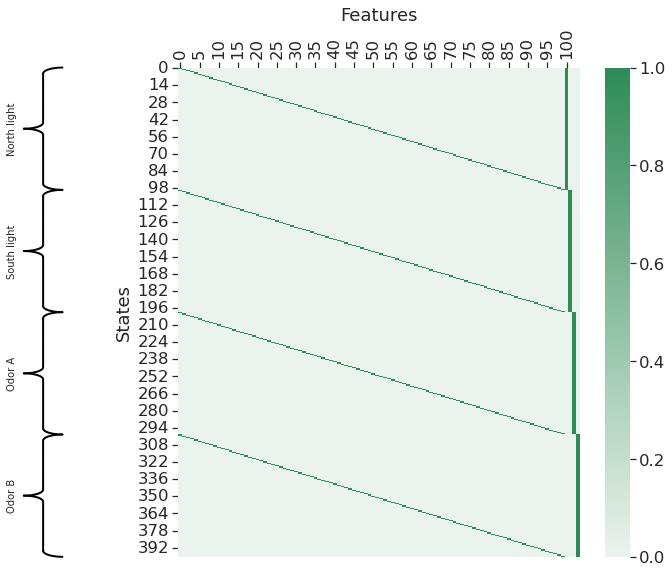

In [15]:
plotting.plot_heatmap(
    matrix=learner.features, title="Features", ylabel="States", braces=braces
)

## States and actions meaning

In [16]:
env.get_states_structure()

OrderedDict([(<LightCues.North: 4>,
              OrderedDict([(0,
                            array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                                   17, 18, 19, 20, 21, 22, 23, 24])),
                           (90,
                            array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
                                   42, 43, 44, 45, 46, 47, 48, 49])),
                           (180,
                            array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
                                   67, 68, 69, 70, 71, 72, 73, 74])),
                           (270,
                            array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
                                   92, 93, 94, 95, 96, 97, 98, 99]))])),
             (<LightCues.South: 20>,
              OrderedDict([(0,
                            array([100, 101, 102, 103, 104, 105, 106, 10

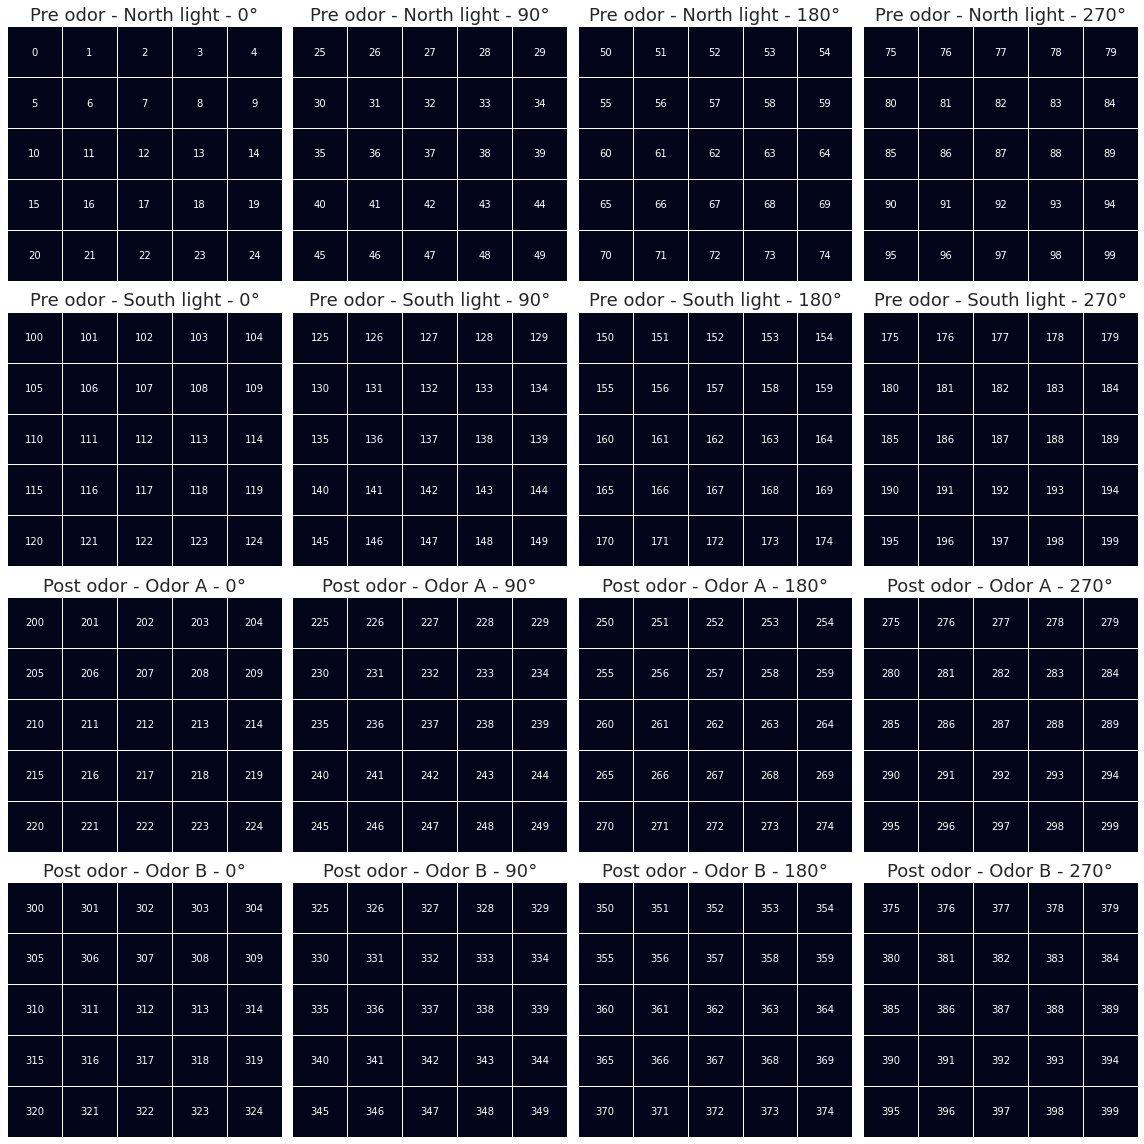

In [17]:
plotting_ego.plot_tiles_locations(
    states_structure=env.get_states_structure(),
    rows=env.rows,
    cols=env.cols,
    contexts_labels=CONTEXTS_LABELS,
)

### Correspondance between flat states and (internal) composite states

In [18]:
state = 63
env.convert_flat_state_to_composite(state)

{'location': 13, 'direction': 180, 'cue': <LightCues.North: 4>}

In [19]:
state = {"location": 13, "direction": 90, "cue": LightCues.North}
env.convert_composite_to_flat_state(state)

38

### Action meaning

In [20]:
action = 0
Actions(action)

<Actions.FORWARD: 0>

## Main loop

In [21]:
rewards = np.zeros((params.numEpisodes, params.n_runs))
steps = np.zeros((params.numEpisodes, params.n_runs))
episodes = np.arange(params.numEpisodes)
qtables = np.zeros((params.n_runs, *learner.Q_hat_table.shape))
all_states = []
all_actions = []

for run in range(params.n_runs):  # Run several times to account for stochasticity
    learner.reset(
        action_size=env.numActions
    )  # Reset the Q-table and the weights between runs

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{params.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            learner.Q_hat_table = learner.Q_hat(learner.weights, learner.features)

            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                qtable=learner.Q_hat_table,
            )

            # Record states and actions
            all_states.append(state)
            all_actions.append(Actions(action).name)

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action, state)

            learner.weights[:, action] = learner.update_weights(
                state, action, reward, new_state
            )

            total_rewards += reward
            step_count += 1

            # Our new state is state
            state = new_state

        # explorer.epsilon = explorer.update_epsilon(episode)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
    qtables[run, :, :] = learner.Q_hat_table

## Postprocessing

In [22]:
res = pd.DataFrame(
    data={
        "Episodes": np.tile(episodes, reps=params.n_runs),
        "Rewards": rewards.flatten(order="F"),
        "Steps": steps.flatten(order="F"),
    }
)
res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
# st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

In [23]:
res

,Episodes,Rewards,Steps,cum_rewards
0,0,10.0,187.0,10.0
1,1,10.0,153.0,20.0
2,2,0.0,18883.0,20.0
3,3,10.0,3043.0,30.0
4,4,10.0,1378.0,40.0
...,...,...,...,...
2995,295,10.0,51.0,1450.0
2996,296,10.0,5762.0,1460.0
2997,297,10.0,4907.0,1470.0
2998,298,0.0,316.0,1470.0


In [24]:
tmp = []
for idx, st in enumerate(tqdm(all_states)):
    tmp.append(env.convert_flat_state_to_composite(st))
all_state_composite = pd.DataFrame(tmp)
all_state_composite

100%|████████████████████████████████████████████████████| 3172511/3172511 [30:26<00:00, 1737.04it/s]


,location,direction,cue
0,21,0,LightCues.North
1,21,270,LightCues.North
2,21,0,LightCues.North
3,21,90,LightCues.North
4,21,0,LightCues.North
...,...,...,...
3172506,20,180,OdorID.A
3172507,20,90,OdorID.A
3172508,21,90,OdorID.A
3172509,22,90,OdorID.A


## Visualization

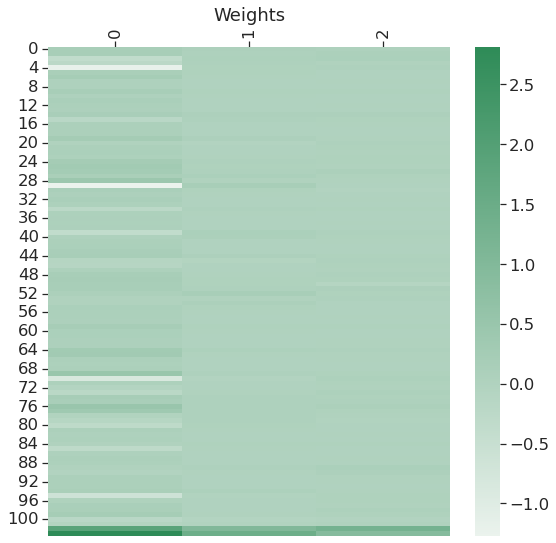

In [25]:
plotting.plot_heatmap(matrix=learner.weights, title="Weights")

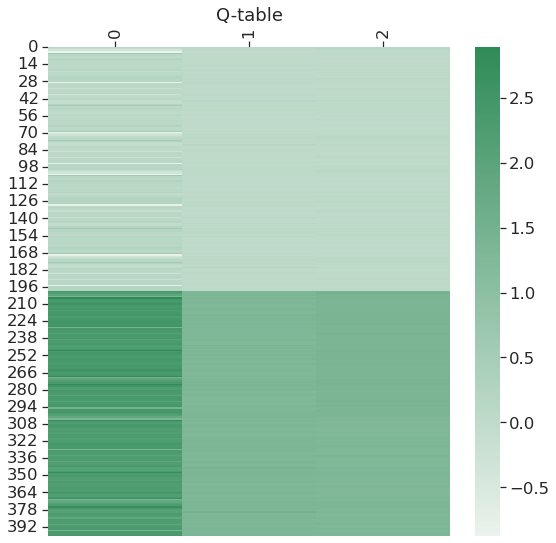

In [26]:
plotting.plot_heatmap(matrix=qtable, title="Q-table")

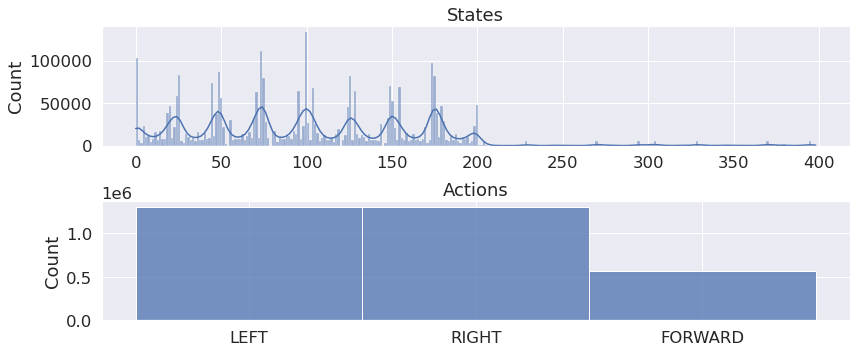

In [27]:
plotting.plot_states_actions_distribution(all_states, all_actions)

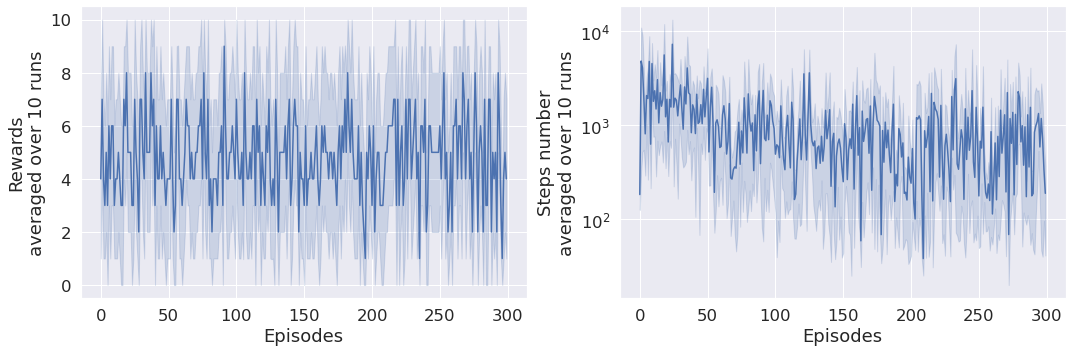

In [28]:
plotting.plot_steps_and_rewards(res, n_runs=params.n_runs, log=True)

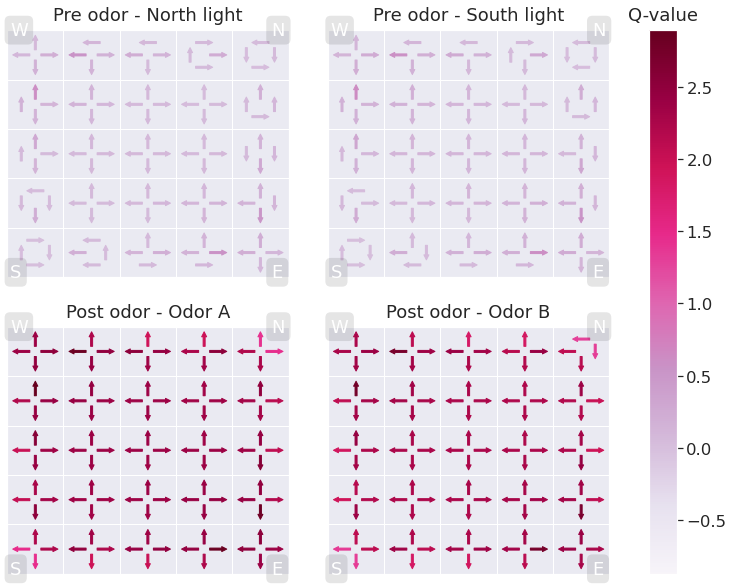

In [35]:
plotting_ego.plot_ego_q_values_maps(
    qtable, env.rows, env.cols, CONTEXTS_LABELS, env.get_states_structure()
)

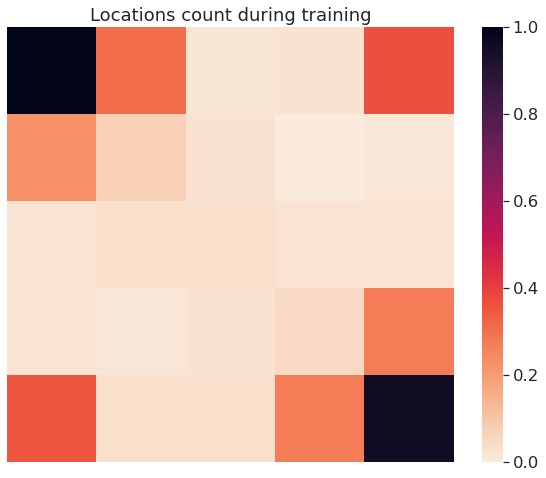

In [30]:
plotting_ego.plot_location_count(
    all_state_composite=all_state_composite,
    tiles_locations=env.tiles_locations,
    cols=env.cols,
    rows=env.rows,
)

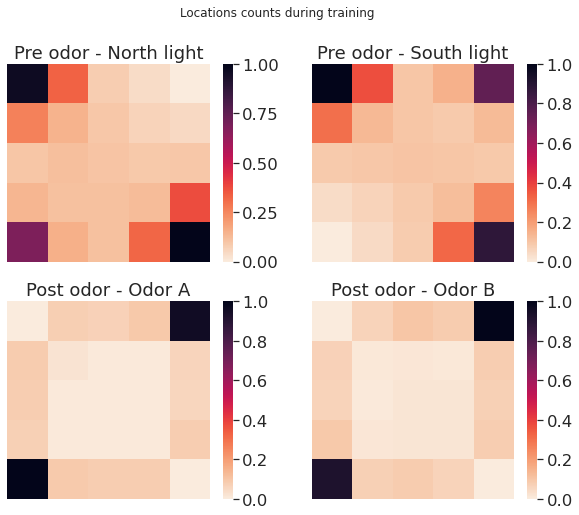

In [31]:
plotting_ego.plot_location_count(
    all_state_composite=all_state_composite,
    tiles_locations=env.tiles_locations,
    cols=env.cols,
    rows=env.rows,
    cues=env.cues,
    contexts_labels=CONTEXTS_LABELS,
)